In [4]:
import matplotlib.pyplot as plt
import geopandas
import cartopy.feature as cfeature
import zipfile
import urllib.request
from cartopy import crs as ccrs
from datetime import datetime, timedelta
from metpy.plots import USCOUNTIES

In [5]:
# Map parameters
domain=[-81.87, -71.87, 40.5, 45.5]
plotCities=True
cities=[{'Name':'Watkins Glen', 'Lat':42.38, 'Lon':-76.87}, {'Name':'Binghamton', 'Lat':42.10, 'Lon':-75.92}, 
                {'Name':'Syracuse', 'Lat':43.04, 'Lon':-76.17}, {'Name':'Rochester', 'Lat':43.16, 'Lon':-77.61}, 
                {'Name':'Albany', 'Lat':42.65, 'Lon':-73.76}, {'Name':'Saranac Lake', 'Lat':44.33, 'Lon':-74.13}, 
                {'Name':'Watertown', 'Lat':43.97, 'Lon':-75.91}, {'Name':'Buffalo', 'Lat':42.89, 'Lon':-78.88},
                {'Name':'Toronto', 'Lat':43.65, 'Lon':-79.38}, {'Name':'Cleveland', 'Lat':41.50, 'Lon':-81.69},
                {'Name':'Scranton', 'Lat':41.41, 'Lon':-75.66}, {'Name':'Erie', 'Lat':42.12, 'Lon':-80.09}, 
                {'Name':'Springfield', 'Lat':42.08, 'Lon':-72.59}, {'Name':'Burlington', 'Lat':44.48, 'Lon':-73.21}, 
                {'Name':'State College', 'Lat':40.79, 'Lon':-77.86}]

dataDIR='/home/pi/bin/data/SPC/'

In [6]:
# Get data
for day in range(3):
    if day+1 <= 3:
        url=f'https://www.spc.noaa.gov/products/outlook/day{day+1}otlk-shp.zip'
    elif day+1 >= 4 and day+1 <= 8:
        url=f'https://www.spc.noaa.gov/products/exper/day4-8/day{day+1}prob-shp.zip'
    
    urllib.request.urlretrieve(url, f'{dataDIR}/spc_outlook_day{day+1}.zip')
    with zipfile.ZipFile(f'{dataDIR}/spc_outlook_day{day+1}.zip', 'r') as zip_ref:
        zip_ref.extractall(f'{dataDIR}/spc_outlook_day{day+1}/')

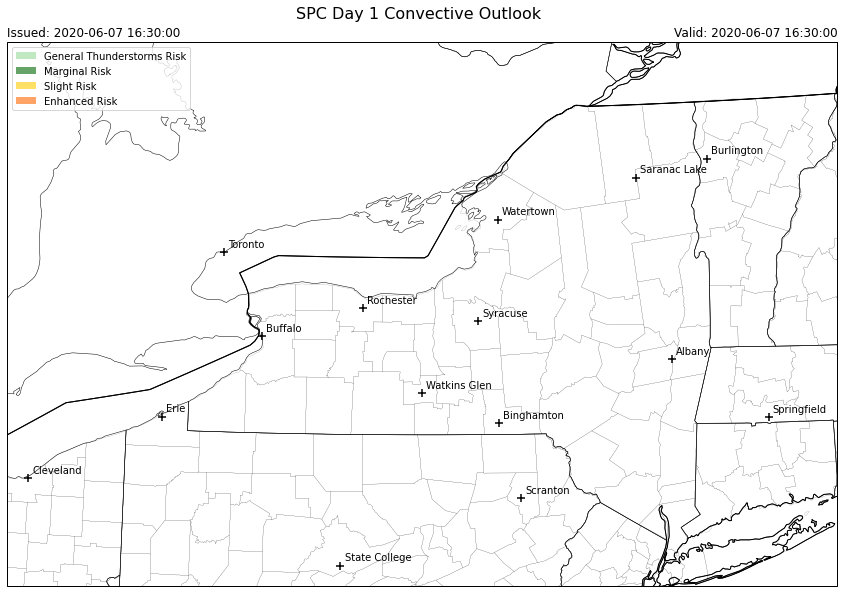

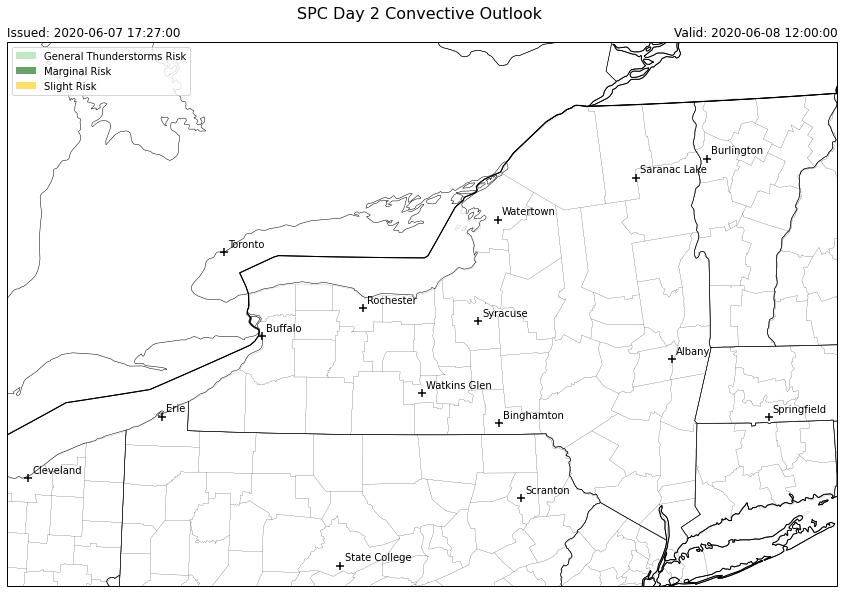

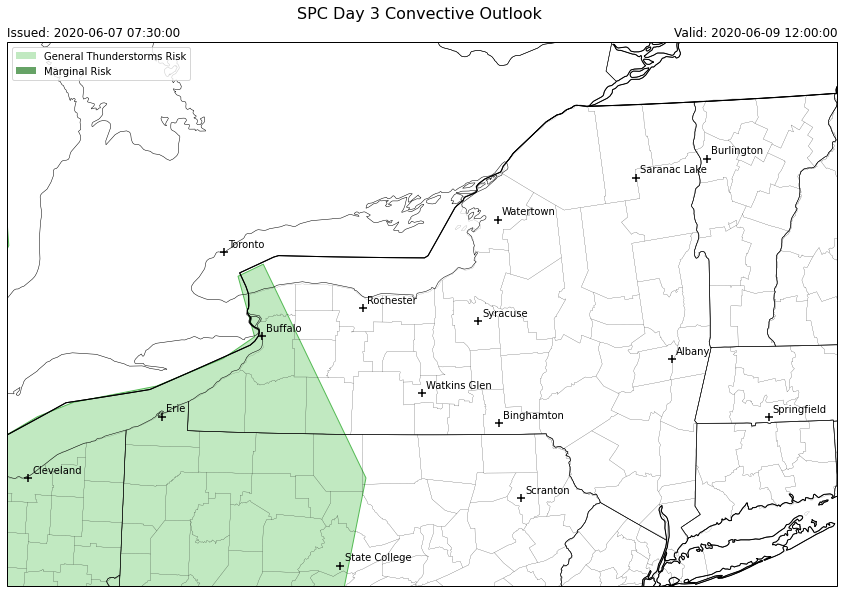

In [7]:
for day in range(3):
    # Load data
    cat_otlk=geopandas.read_file(f'{dataDIR}/spc_outlook_day{day+1}/day{day+1}otlk_cat.shp')

    # Read meta data
    validTime=cat_otlk['VALID'][0]
    validTime=datetime.strptime(validTime, '%Y%m%d%H%M')
    expireTime=cat_otlk['EXPIRE'][0]
    expireTime=datetime.strptime(expireTime, '%Y%m%d%H%M')
    issueTime=cat_otlk['ISSUE'][0]
    issueTime=datetime.strptime(issueTime, '%Y%m%d%H%M')

    # set up the figure
    fig = plt.figure(figsize=(18, 10))

    # Generate an Cartopy projection
    crs=ccrs.PlateCarree()
    proj = ccrs.Stereographic(central_longitude=(domain[1]-domain[0])/2+domain[0], central_latitude=(domain[3]-domain[2])/2+domain[2])
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_extent(domain, crs=crs)
    
    # Plot outlook
    cat_otlk.plot(ax=ax, facecolor=cat_otlk['fill'], edgecolor=cat_otlk['stroke'], transform=ccrs.Geodetic())
    
    # Add legend
    import matplotlib.patches as mpatches
    patches=[]
    for fill, stroke, label in zip(cat_otlk['fill'], cat_otlk['fill'], cat_otlk['LABEL2']):
        patches.append(mpatches.Patch(edgecolor=None, facecolor=fill, label=label))
    ax.legend(handles=patches, loc='upper left')
    
    # Add geographic features
    country_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', scale='10m', facecolor='none')
    ax.add_feature(country_borders, edgecolor='black', linewidth=1.0)
    state_borders=cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lakes', scale='10m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=0.5)
    ax.add_feature(USCOUNTIES.with_scale('5m'), edgecolor='black', linewidth=0.1)

    # Add Places
    if plotCities:
        for city in cities:
            ax.scatter(city['Lon'], city['Lat'], marker='+', c='k', s=50, transform=ccrs.Geodetic())
            ax.text(city['Lon']+0.05, city['Lat']+0.05, city['Name'], transform=ccrs.Geodetic())
    
    # Add Headers
    plt.title(f'Issued: {issueTime}', loc='left')
    plt.title(f'Valid: {validTime}', loc='right')
    plt.suptitle(f'SPC Day {day+1} Convective Outlook', fontsize=16, x=0.51, y=0.93)

    plt.show()
    
    # Export fig and close
    exportPath='/home/humphreys/weather.carterhumphreys.com/bin/SPC/'
    #fig.savefig(f'{exportPath}/spc_day{day+1}otlk_cat.png', bbox_inches='tight', dpi=100)
    #plt.clf()